In [1]:
# Install dlroms if needed

try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

In [2]:
# Import libraries

import numpy as np
from dlroms import *
from dlroms.dnns import *
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch
from dolfin import *
import time

In [3]:
# Read files from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "./gdrive/MyDrive/DL-ROMs/high-fidelity"

/content/gdrive/.shortcut-targets-by-id/1Dufiwr_UU6MjsJZw_f9BfKH-B5DETJ04/DL-ROMs/high-fidelity


In [4]:
%cd "./gdrive/MyDrive/Colab Notebooks/DL-ROMs/high-fidelity"

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs/high-fidelity


In [16]:
# Flags

generateData = False
useGPU = True

if useGPU:
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Random seeds

rnd.seed(0)
torch.manual_seed(0)

In [8]:
# Domain and mesh definition

h = 0.01 													          																		# Mesh size
n = 100												              																		# Number of cells (1/h)

# Generate mesh with gmsh
# D = fe.rectangle((0,0), (1,1)) 																								# Square domain
# mesh = fe.mesh(D, stepsize=h) 																								# Mesh (stepsize parameter available with gmsh)

# Generate mesh with FEniCS
mesh = fe.unitsquaremesh(n, n)																									# Mesh

V = fe.space(mesh, 'CG', 1) 																										# Continuous piecewise linear finite elements
Nh = V.dim() 												        																		# Space dimension (number of dofs)

In [9]:
# Snapshot generation

def generateSnapshots(N, V):
	"""
	Generate N pairs (mu, u) of parameters and solutions in the FE space V.
	"""

	# Generate mu

	mu = np.zeros((N, 4))

	for i in range(N):
		mu[i] = rnd.uniform(0., 1., size=(1, 4))

	mu1, mu2, mu3, mu4 = mu[:, 0], mu[:, 1], mu[:, 2], mu[:, 3]

	# Generate u

	Nh = V.dim()
	u = np.zeros((N, Nh))

	u_D = Expression('0.01', degree=0)

	def boundary(x, on_boundary):
		return on_boundary

	bc = DirichletBC(V, u_D, boundary) 																						# Dirichlet boundary conditions

	f = Expression('100 * (x[0] * x[1] - x[1] * x[1])', degree=2)									# Source term

	for i in range(N):

		if i % 100 == 0:
			print('Snapshot {}/{}'.format(i, N))

		sigma = Expression('6 + 5 * tanh(20 * (x[1] + 10 * mu1 * x[0] * (x[0] - 1) * (x[0] - mu2) * (x[0] - mu3) - 0.5))',
											 degree=2, mu1=mu1[i], mu2=mu2[i], mu3=mu3[i])						# Diffusion coefficient

		beta = Expression(('10 * cos(2 * pi * mu4)', '10 * sin(2 * pi * mu4)'),
											 degree=2, mu4=mu4[i], pi=np.pi)		                      # Advection coefficient

		uu = TrialFunction(V)
		v = TestFunction(V)

		F = sigma * dot(grad(uu), grad(v)) * dx + \
				dot(beta, grad(uu)) * v * dx - f * v * dx							                  # Variational formulation
		a, L = lhs(F), rhs(F)

		uu = Function(V)																														# Solution function

		solve(a == L, uu, bc)																												# Solution of the variational problem

		u[i] = uu.vector()

	return mu, u

In [10]:
# Sampling of the training and test sets

training_size = 600
test_size = 5000

if generateData:

	start = time.time()
	mu_train, u_train = generateSnapshots(training_size, V)
	end = time.time()
	print('Snapshots generation time: {:.2f}s'.format(end - start))

	# mu_test, u_test = generateSnapshots(test_size, V)

	np.save('mu_train_'+str(training_size)+'.npy', mu_train)
	# np.save('mu_test.npy', mu_test)
	np.save('u_train_'+str(training_size)+'.npy', u_train)
	# np.save('u_test.npy', u_test)

Snapshot 0/600
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_fc4e338dac2320e56a2ddb4fd65d52c41cd0b40b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_12]'
  Unique elements:           'CG1(?,?), CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), CG2(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0649555 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00295162 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0180752 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6ab56968c6ffa883272fd990bd40fad8bf858cca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00638604 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0156925 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00591969 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.01478 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:F

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_03a522750c77f7aae52f7fa78859d6e0e405ac66

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_13, f_14]'
  Unique elements:           'CG1(?,?), CG2(?,?), Vector<2 x CG2(?,?)>, Vector<2 x C
                             G1(?,?)>'
  Unique sub elements:       'CG1(?,?), CG2(?,?), Vector<2 x CG2(?,?)>, Vector<2 x C
       

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00289798 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0163283 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Snapshot 100/600
Snapshot 200/600
Snapshot 300/600
Snapshot 400/600
Snapshot 500/600
Snapshots generation time: 201.84s


In [ ]:
# Snapshots generation time (600): 3m 22s
# Snapshots generation time (1200): 7m 17s
# Snapshots generation time (2400): 13m 20s

In [17]:
# Load snapshots

if not generateData:

	mu_train = np.load('mu_train_'+str(training_size)+'.npy')
	mu_test = np.load('mu_test.npy')
	u_train = np.load('u_train_'+str(training_size)+'.npy')
	u_test = np.load('u_test.npy')

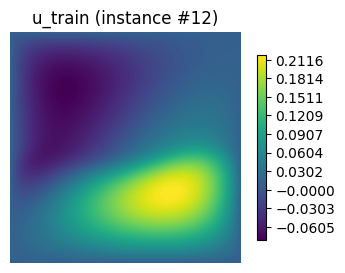

In [13]:
# Print snapshot

index = 12

plt.figure(figsize=(4, 3))
fe.plot(u_train[index, :], V, colorbar=True)
plt.title('u_train (instance #' + str(index) + ')')
plt.show()

In [14]:
# Traning architecture

m = 16																																					# Decoder
k = 4																																						# Dense NN

# class Dense(Layer):
# 	 def __init__(self, input_dim, output_dim, activation = leakyReLU):
# 		...

# class Deconv2D(Layer):
#    def __init__(self, window, channels = (1,1), stride = 1, padding = 0, groups = 1, dilation = 1, activation = leakyReLU):
# 		...
# torch.nn.ConvTranspose2d(channels[0], channels[1], window, stride = stride, padding = padding, groups = groups, dilation = dilation)
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

# The input and output dimensions are written in the form height x width x channels (vectors reshaped in 3D tensors)

torch.set_default_dtype(torch.float32)

psi_prime = Dense(Nh, 4, activation=None)

psi = Dense(4, 100 * m) + \
			Reshape(4 * m, 5, 5) + \
			Deconv2D(11, (4 * m, 2 * m), 2) + \
			Deconv2D(10, (2 * m, m), 2) + \
			Deconv2D(11, (m, 1), 2, activation=None) + \
			Reshape(-1)

phi = Dense(4, 50 * k) + \
			Dense(50 * k, 50 * k) + \
			Dense(50 * k, 4, activation=None)

print("Trainable parameters:")
print(" Encoder:", psi_prime.dof())
print(" Decoder:", psi.dof())
print(" Dense NN:", phi.dof())

Trainable parameters:
 Encoder: 40808
 Decoder: 308993
 Dense NN: 42004


In [ ]:
psi.dims()

'4 -> 1600 -> (64, 5, 5) -> (32, 19, 19) -> (16, 46, 46) -> (1, 101, 101) -> 10201'

In [18]:
# Convert NumPy arrays to tensors on the selected device

u_train = torch.tensor(u_train, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test, dtype=torch.float32).to(device)
mu_train = torch.tensor(mu_train, dtype=torch.float32).to(device)
mu_test = torch.tensor(mu_test, dtype=torch.float32).to(device)

In [19]:
# Train the autoencoder (nonlinear dimensionality reduction)

autoencoder = DFNN(psi_prime, psi)																							# Encoder + decoder
autoencoder.He()																																# He initialization

# def train(self, mu, u, ntrain, epochs, optim = torch.optim.LBFGS, lr = 1, loss = None, error = None, nvalid = 0,
#           verbose = True, refresh = True, notation = 'e', title = None, batchsize = None, slope = 1.0)

# Learning rate, minibatch?

autoencoder.to(device)

autoencoder.train(u_train, u_train, ntrain=training_size, epochs=200, loss=mre(euclidean), verbose=True)

		Train		Test
Epoch 200:	3.47e-02	nan.

>> ETA: 1.60s.

Training complete. Elapsed time: 5 minutes 20.19 seconds.


In [ ]:
# Autoencoder training time (T4 GPU, 600): 5m 21s
# Autoencoder training time (T4 GPU, 1200): 11m 44s
# Autoencoder training time (T4 GPU, 2400): 22m 8s

In [20]:
# Use the trained encoder to generate the reduced order version of the dataset

autoencoder.freeze()

psi_prime.eval()

with torch.no_grad():
  u_train_ro = psi_prime(u_train)

In [21]:
# Use the reduced dataset to train the dense NN mapping the parameters to the reduced order solution

phi = DFNN(phi)
phi.He()

phi.to(device)

phi.train(mu_train, u_train_ro, ntrain=training_size, epochs=200, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 200:	1.23e-01	nan.

>> ETA: 0.29s.

Training complete. Elapsed time: 58.23 seconds.


In [ ]:
# Dense NN training time (T4 GPU, 600): 58s
# Dense NN training time (T4 GPU, 1200): 1m 3s
# Dense NN training time (T4 GPU, 2400): 1m 1s

In [22]:
# Use the dense NN to predict the reduced order solution and the decoder to restore the full order solution

phi.eval()
psi.eval()

with torch.no_grad():
  u_train_pred = psi(phi(mu_train))

In [23]:
# Compute the relative error

error_train = torch.norm(u_train - u_train_pred, dim=1) / torch.norm(u_train, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

Relative training error: 4.15%


In [ ]:
# Relative training error (600): 4.15%
# Relative training error (1200): 3.61%
# Relative training error (2400): 4.08%

In [24]:
# Apply the model to the test set

with torch.no_grad():
  u_test_pred = psi(phi(mu_test))

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative test error: 6.72%


In [ ]:
# Relative test error (600): 6.72%
# Relative test error (1200): 4.90%
# Relative test error (2400): 4.59%

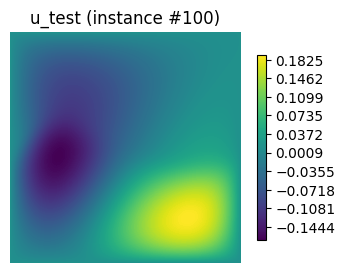

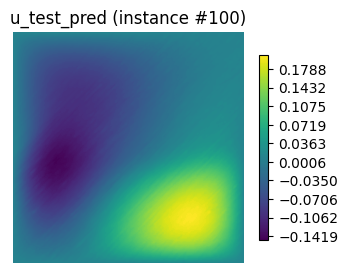

In [25]:
# Plot some results

index = 100

plt.figure(figsize=(4, 3))
fe.plot(u_test[index, :], V, colorbar=True)
plt.title('u_test (instance #' + str(index) + ')')

plt.figure(figsize=(4, 3))
fe.plot(u_test_pred[index, :], V, colorbar=True)
plt.title('u_test_pred (instance #' + str(index) + ')')

plt.show()